In [1]:
%load_ext autoreload
%autoreload 2

# 路由模式
  - 路由模式通过条件逻辑引导代理从固定执行路径转向更灵活的子流程，实现动态和上下文感知的决策。
  - 具体例子包括根据用户意图路由至不同子代理（如订单状态查询、产品信息、技术支持等）。
  - 路由实现方式有四种：基于LLM的路由、基于嵌入的路由、基于规则的路由和基于机器学习模型的路由。
  - LLM路由通过提示语言模型分析输入，决定下一步动作。
  - 嵌入路由将查询映射到向量空间，依照语义匹配进行路由。
  - 规则路由使用预定义逻辑（如if-else）执行决策，简单且快速。
  - 机器学习模型路由基于训练过的分类器，能处理复杂且多样的路由需求。
  - 路由机制可在处理流程不同阶段应用，动态选择合适工具。

## 实践应用与用例：
  - 路由模式是自适应智能代理设计中的关键控制机制，使系统根据输入和内部状态动态调整行为。
  - 在人机交互应用（如虚拟助理、AI导师）中，实现自然语言意图理解并路由至适合模块，提高响应准确性。
  - 在数据处理和文档处理管道中，路由用于分类分发不同类型的数据（邮件、客服请求、API负载等）。
  - 在复杂系统中，路由作为高级调度器协调多专业工具或代理，分配任务以提升整体效率。
  - 路由模式增强系统灵活性，使其能够在多个工具和子系统间做出智能选择，支持功能多样化和上下文感知。
  - 终极目标是使系统从静态执行者变成能够动态决策和调整的智能体，根据环境和任务条件优化处理路径。

## 实战示例

```
pip install langchain langgraph google-cloud-aiplatform langchain-google-genai google-adk deprecated pydantic
```



In [2]:

import dotenv
dotenv.load_dotenv()


True

In [27]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableBranch

In [38]:
try:
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
    # llm = ChatOpenAI(base_url="http://127.0.0.1:1234/v1", temperature=0, api_key="not-needed")
    print(f"Language model initialized: {llm.model}")
except Exception as e:
    print(f"Error initializing language model: {e}")
    llm = None

Language model initialized: gemini-2.5-flash


In [39]:
# --- 定义模拟的子智能体处理器 (等同于 ADK 中的 sub_agents) ---

def booking_handler(request: str) -> str:
    """Simulates the Booking Agent handling a request."""
    print("\n--- DELEGATING TO BOOKING HANDLER ---")
    return f"Booking Handler processed request: '{request}'. Result: Simulated booking action."

def info_handler(request: str) -> str:
    """Simulates the Info Agent handling a request."""
    print("\n--- DELEGATING TO INFO HANDLER ---")
    return f"Info Handler processed request: '{request}'. Result: Simulated information retrieval."

def unclear_handler(request: str) -> str:
    """Handles requests that couldn't be delegated."""
    print("\n--- HANDLING UNCLEAR REQUEST ---")
    return f"Coordinator could not delegate request: '{request}'. Please clarify."

In [40]:
# --- 定义协调员的路由链 (等同于 ADK 协调员的指令) ---
# 这个链负责决定将任务委派给哪个处理器。
coordinator_router_prompt = ChatPromptTemplate.from_messages([
    ("system", """Analyze the user's request and determine which specialist handler should process it.
     - If the request is related to booking flights or hotels, output 'booker'.
     - For all other general information questions, output 'info'.
     - If the request is unclear or doesn't fit either category, output 'unclear'.
     ONLY output one word: 'booker', 'info', or 'unclear'."""),
    ("user", "{request}")
])

In [41]:
if llm:
    coordinator_router_chain = coordinator_router_prompt | llm | StrOutputParser()

In [42]:
# 为 RunnableBranch 定义分支
branches = {
    "booker": RunnablePassthrough.assign(output=lambda x: booking_handler(x)),
    "info": RunnablePassthrough.assign(output=lambda x: info_handler(x['request']['request'])),
    "unclear": RunnablePassthrough.assign(output=lambda x: unclear_handler(x['request']['request'])),
}

In [43]:
# 创建 RunnableBranch。它会接收路由链的输出，
# 并将原始输入 ('request') 路由到相应的处理器。
delegation_branch = RunnableBranch(
    (lambda x: x['decision'].strip() == 'booker', branches["booker"]), # Added .strip()
    (lambda x: x['decision'].strip() == 'info', branches["info"]),     # Added .strip()
    branches["unclear"] # Default branch for 'unclear' or any other output
)

In [44]:
# 将路由链和委派分支组合成一个可执行单元
# 路由链的输出 ('decision') 会连同原始输入 ('request') 一起
# 传递给 delegation_branch。
coordinator_agent = {
    "decision": coordinator_router_chain,
    "request": RunnablePassthrough()
} | delegation_branch | (lambda x: x['output']) # Extract the final output

In [45]:
# --- 使用示例 ---
def main():
    if not llm:
        print("\nSkipping execution due to LLM initialization failure.")
        return
    print("--- Running with a booking request ---")
    request_a = "Book me a flight to London."
    result_a = coordinator_agent.invoke({"request": request_a})
    print(f"Final Result A: {result_a}")

    print("\n--- Running with an info request ---")
    request_b = "What is the capital of Italy?"
    result_b = coordinator_agent.invoke({"request": request_b})
    print(f"Final Result B: {result_b}")

    print("\n--- Running with an unclear request ---")
    request_c = "Tell me about quantum physics."
    result_c = coordinator_agent.invoke({"request": request_c})
    print(f"Final Result C: {result_c}")

if __name__ == "__main__":
    main()

--- Running with a booking request ---

--- DELEGATING TO BOOKING HANDLER ---
Final Result A: Booking Handler processed request: '{'decision': 'booker', 'request': {'request': 'Book me a flight to London.'}}'. Result: Simulated booking action.

--- Running with an info request ---

--- DELEGATING TO INFO HANDLER ---
Final Result B: Info Handler processed request: 'What is the capital of Italy?'. Result: Simulated information retrieval.

--- Running with an unclear request ---

--- DELEGATING TO INFO HANDLER ---
Final Result C: Info Handler processed request: 'Tell me about quantum physics.'. Result: Simulated information retrieval.


- 该Python代码使用LangChain库和Google的生成式AI模型gemini-2.5-flash，构建了一个简单的类似代理(agent)系统。
- 定义了三个模拟的子代理处理函数：booking_handler、info_handler和unclear_handler，分别处理不同类型的请求。
- 核心组件是coordinator_router_chain，它使用ChatPromptTemplate指示语言模型将用户请求分类为'booker'、'info'或'unclear'三类。
- 路由链的输出通过RunnableBranch分配给对应的子代理处理函数，根据语言模型的决策引导请求数据至相应处理器。
- coordinator代理结合这些组件，先对请求进行决策路由，再将请求传递给选择的处理器，最终从处理器的响应中获取输出。
- 主函数演示了系统的使用，展示了如何将不同输入路由并由模拟代理处理。
- 实现了语言模型初始化的错误处理，确保系统的稳健性。
- 代码结构模拟了一个基本的多代理框架，由中央协调器根据意图将任务委派给专门的代理。

## Agent Development Kit (ADK)
- Agent Development Kit (ADK) 是一个用于工程智能体系统的框架，提供结构化环境来定义智能体的能力和行为。
- 与基于显式计算图的架构不同，ADK 范式中通过定义一组代表智能体功能的“工具”来实现路由。
- 框架的内部逻辑根据用户查询，使用底层模型将用户意图匹配到正确的功能处理器。
- Python 代码示例演示了使用 Google ADK 库开发的 Agent Development Kit 应用。
- 该示例设置了一个“协调员”智能体，根据定义的指令将用户请求路由到专业子智能体，如“Booker”用于预订，“Info”用于一般信息。
- 子智能体使用特定工具模拟处理请求，展示了智能体系统内的基本委派模式。

In [46]:
import uuid
from typing import Dict, Any, Optional

from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.adk.tools import FunctionTool
from google.genai import types
from google.adk.events import Event

In [49]:
# --- 定义工具函数 ---
# 这些函数模拟了专业智能体的具体行动。
def booking_handler(request: str) -> str:
    """
    Handles booking requests for flights and hotels.
    Args:
        request: The user's request for a booking.
    Returns:
        A confirmation message that the booking was handled.
    """
    print("-------------------------- Booking Handler Called ----------------------------")
    return f"Booking action for '{request}' has been simulated."

def info_handler(request: str) -> str:
    """
    Handles general information requests.
    Args:
        request: The user's question.
    Returns:
        A message indicating the information request was handled.
    """
    print("-------------------------- Info Handler Called ----------------------------")
    return f"Information request for '{request}'. Result: Simulated information retrieval."

def unclear_handler(request: str) -> str:
    """Handles requests that couldn't be delegated."""
    return f"Coordinator could not delegate request: '{request}'. Please clarify."

In [55]:
# --- 从函数创建工具 ---
booking_tool = FunctionTool(booking_handler)
info_tool = FunctionTool(info_handler)

In [56]:
# --- 定义配备了各自工具的专业子智能体 ---
booking_agent = Agent(
    name="Booker",
    model="gemini-2.0-flash",
    description="A specialized agent that handles all flight and hotel booking requests by calling the booking tool.",
    tools=[booking_tool]
)

info_agent = Agent(
    name="Info",
    model="gemini-2.0-flash",
    description="A specialized agent that provides general information and answers user questions by calling the info tool.",
    tools=[info_tool]
)

In [57]:
# --- 定义带有明确委派指令的父智能体 ---
coordinator = Agent(
    name="Coordinator",
    model="gemini-2.0-flash",
    instruction=(
        "You are the main coordinator. Your only task is to analyze incoming user requests "
        "and delegate them to the appropriate specialist agent. Do not try to answer the user directly.\n"
        "- For any requests related to booking flights or hotels, delegate to the 'Booker' agent.\n"
        "- For all other general information questions, delegate to the 'Info' agent."
    ),
    description="A coordinator that routes user requests to the correct specialist agent.",
    # The presence of sub_agents enables LLM-driven delegation (Auto-Flow) by default.
    # 定义了 sub_agents 默认就会启用由大语言模型驱动的委派。
    sub_agents=[booking_agent, info_agent]
)

In [58]:
# --- 执行逻辑 ---
def run_coordinator(runner: InMemoryRunner, request: str):
    """用给定的请求运行协调员智能体并进行委派。"""
    print(f"\n--- Running Coordinator with request: '{request}' ---")
    final_result = ""
    try:
        user_id = "user_123"
        session_id = str(uuid.uuid4())
        runner.session_service.create_session(
            app_name=runner.app_name, user_id=user_id, session_id=session_id
        )

        for event in runner.run(
            user_id=user_id,
            session_id=session_id,
            new_message=types.Content(
                role='user',
                parts=[types.Part(text=request)]
            ),
        ):
            if event.is_final_response() and event.content:
                # Try to get text directly from event.content to avoid iterating parts
                if hasattr(event.content, 'text') and event.content.text:
                     final_result = event.content.text
                elif event.content.parts:
                    # Fallback: Iterate through parts and extract text (might trigger warning)
                    text_parts = [part.text for part in event.content.parts if part.text]
                    final_result = "".join(text_parts)
                # Assuming the loop should break after the final response
                break

        print(f"Coordinator Final Response: {final_result}")
        return final_result
    except Exception as e:
        print(f"An error occurred while processing your request: {e}")
        return f"An error occurred while processing your request: {e}"

In [59]:
def main():
    """Main function to run the ADK example."""
    """运行 ADK 示例的主函数。"""
    print("--- Google ADK Routing Example (ADK Auto-Flow Style) ---")
    print("Note: This requires Google ADK installed and authenticated.")

    runner = InMemoryRunner(coordinator)
    # Example Usage
    # 使用示例
    result_a = run_coordinator(runner, "Book me a hotel in Paris.")
    print(f"Final Output A: {result_a}")
    result_b = run_coordinator(runner, "What is the highest mountain in the world?")
    print(f"Final Output B: {result_b}")
    result_c = run_coordinator(runner, "Tell me a random fact.") # Should go to Info
    print(f"Final Output C: {result_c}")
    result_d = run_coordinator(runner, "Find flights to Tokyo next month.") # Should go to Booker
    print(f"Final Output D: {result_d}")

main()

C:\Users\yuw1si\AppData\Local\Temp\ipykernel_17840\1530949855.py:9: RuntimeWarning: coroutine 'InMemorySessionService.create_session' was never awaited
  runner.session_service.create_session(
Exception in thread Thread-5 (_asyncio_thread_main):
Traceback (most recent call last):
  File "c:\Users\yuw1si\.conda\envs\my_root\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\yuw1si\.conda\envs\my_root\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\yuw1si\.conda\envs\my_root\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yuw1si\.conda\envs\my_root\Lib\site-packages\google\adk\runners.py", line 436, in _asyncio_thread_main
    asyncio.run(_invoke_run_async())
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yuw1si\.conda\envs\my_root\Lib\asynci

--- Google ADK Routing Example (ADK Auto-Flow Style) ---
Note: This requires Google ADK installed and authenticated.

--- Running Coordinator with request: 'Book me a hotel in Paris.' ---
Coordinator Final Response: 
Final Output A: 

--- Running Coordinator with request: 'What is the highest mountain in the world?' ---
Coordinator Final Response: 
Final Output B: 

--- Running Coordinator with request: 'Tell me a random fact.' ---
Coordinator Final Response: 
Final Output C: 

--- Running Coordinator with request: 'Find flights to Tokyo next month.' ---
Coordinator Final Response: 
Final Output D: 


DataSurfer 的 Agent Tool 装饰器简化了工具函数的定义，使其易于集成到智能体系统中。

In [61]:
import datasurfer as ds
from datasurfer.lib_llm.utility import agent_tool

In [62]:
@agent_tool
def booking_handler(request: str) -> str:
    """
    Handles booking requests for flights and hotels.
    Args:
        request: The user's request for a booking.
    Returns:
        A confirmation message that the booking was handled.
    """
    print("-------------------------- Booking Handler Called ----------------------------")
    return f"Booking action for '{request}' has been simulated."

@agent_tool
def info_handler(request: str) -> str:
    """
    Handles general information requests.
    Args:
        request: The user's question.
    Returns:
        A message indicating the information request was handled.
    """
    print("-------------------------- Info Handler Called ----------------------------")
    return f"Information request for '{request}'. Result: Simulated information retrieval."

@agent_tool
def unclear_handler(request: str) -> str:
    """Handles requests that couldn't be delegated."""
    return f"Coordinator could not delegate request: '{request}'. Please clarify."

In [64]:
instruction=(
    "You are the main coordinator. Your only task is to analyze incoming user requests "
    "and delegate them to the appropriate specialist agent. Do not try to answer the user directly.\n"
    "- For any requests related to booking flights or hotels, call tool 'booking_handler'.\n"
    "- For all other general information questions, call tool 'info_handler'.\n"
    "If the request is unclear or doesn't fit either category, call tool 'unclear_handler'."
)

In [ ]:
agent = ds.Agent('LA', instructions=instruction, tools=[
                                                        booking_handler,
                                                        info_handler,
                                                        unclear_handler
                                                    ])

In [72]:
agent.resp("Book me a hotel in Paris.", silent=True);

-------------------------- Booking Handler Called ----------------------------


In [73]:
agent.resp("What is the highest mountain in the world?", silent=True);

-------------------------- Info Handler Called ----------------------------


## 路由模式的重要性
- 代理系统需要应对多种输入和情境，单一线性流程无法满足决策需求。
- 缺乏选择正确工具或子流程的机制导致系统刚性且不具适应性，难以处理复杂多变的用户请求。
- 路由模式通过引入条件逻辑，标准化代理的操作框架。
- 路由模式使系统能先分析查询意图，再动态指引控制流至合适的工具、功能或子代理。
- 决策方式多样，可通过提示大型语言模型、应用预定义规则或基于语义相似度的嵌入等方法实现。
- 路由模式将固定执行路径转变为灵活且上下文感知的工作流，优化决策选择。
- 适用于需要在多工作流、工具或子代理间根据用户输入或状态进行选择的场景。
- 关键应用包括客户支持机器人，需区分销售询问、技术支持和账户管理等不同任务
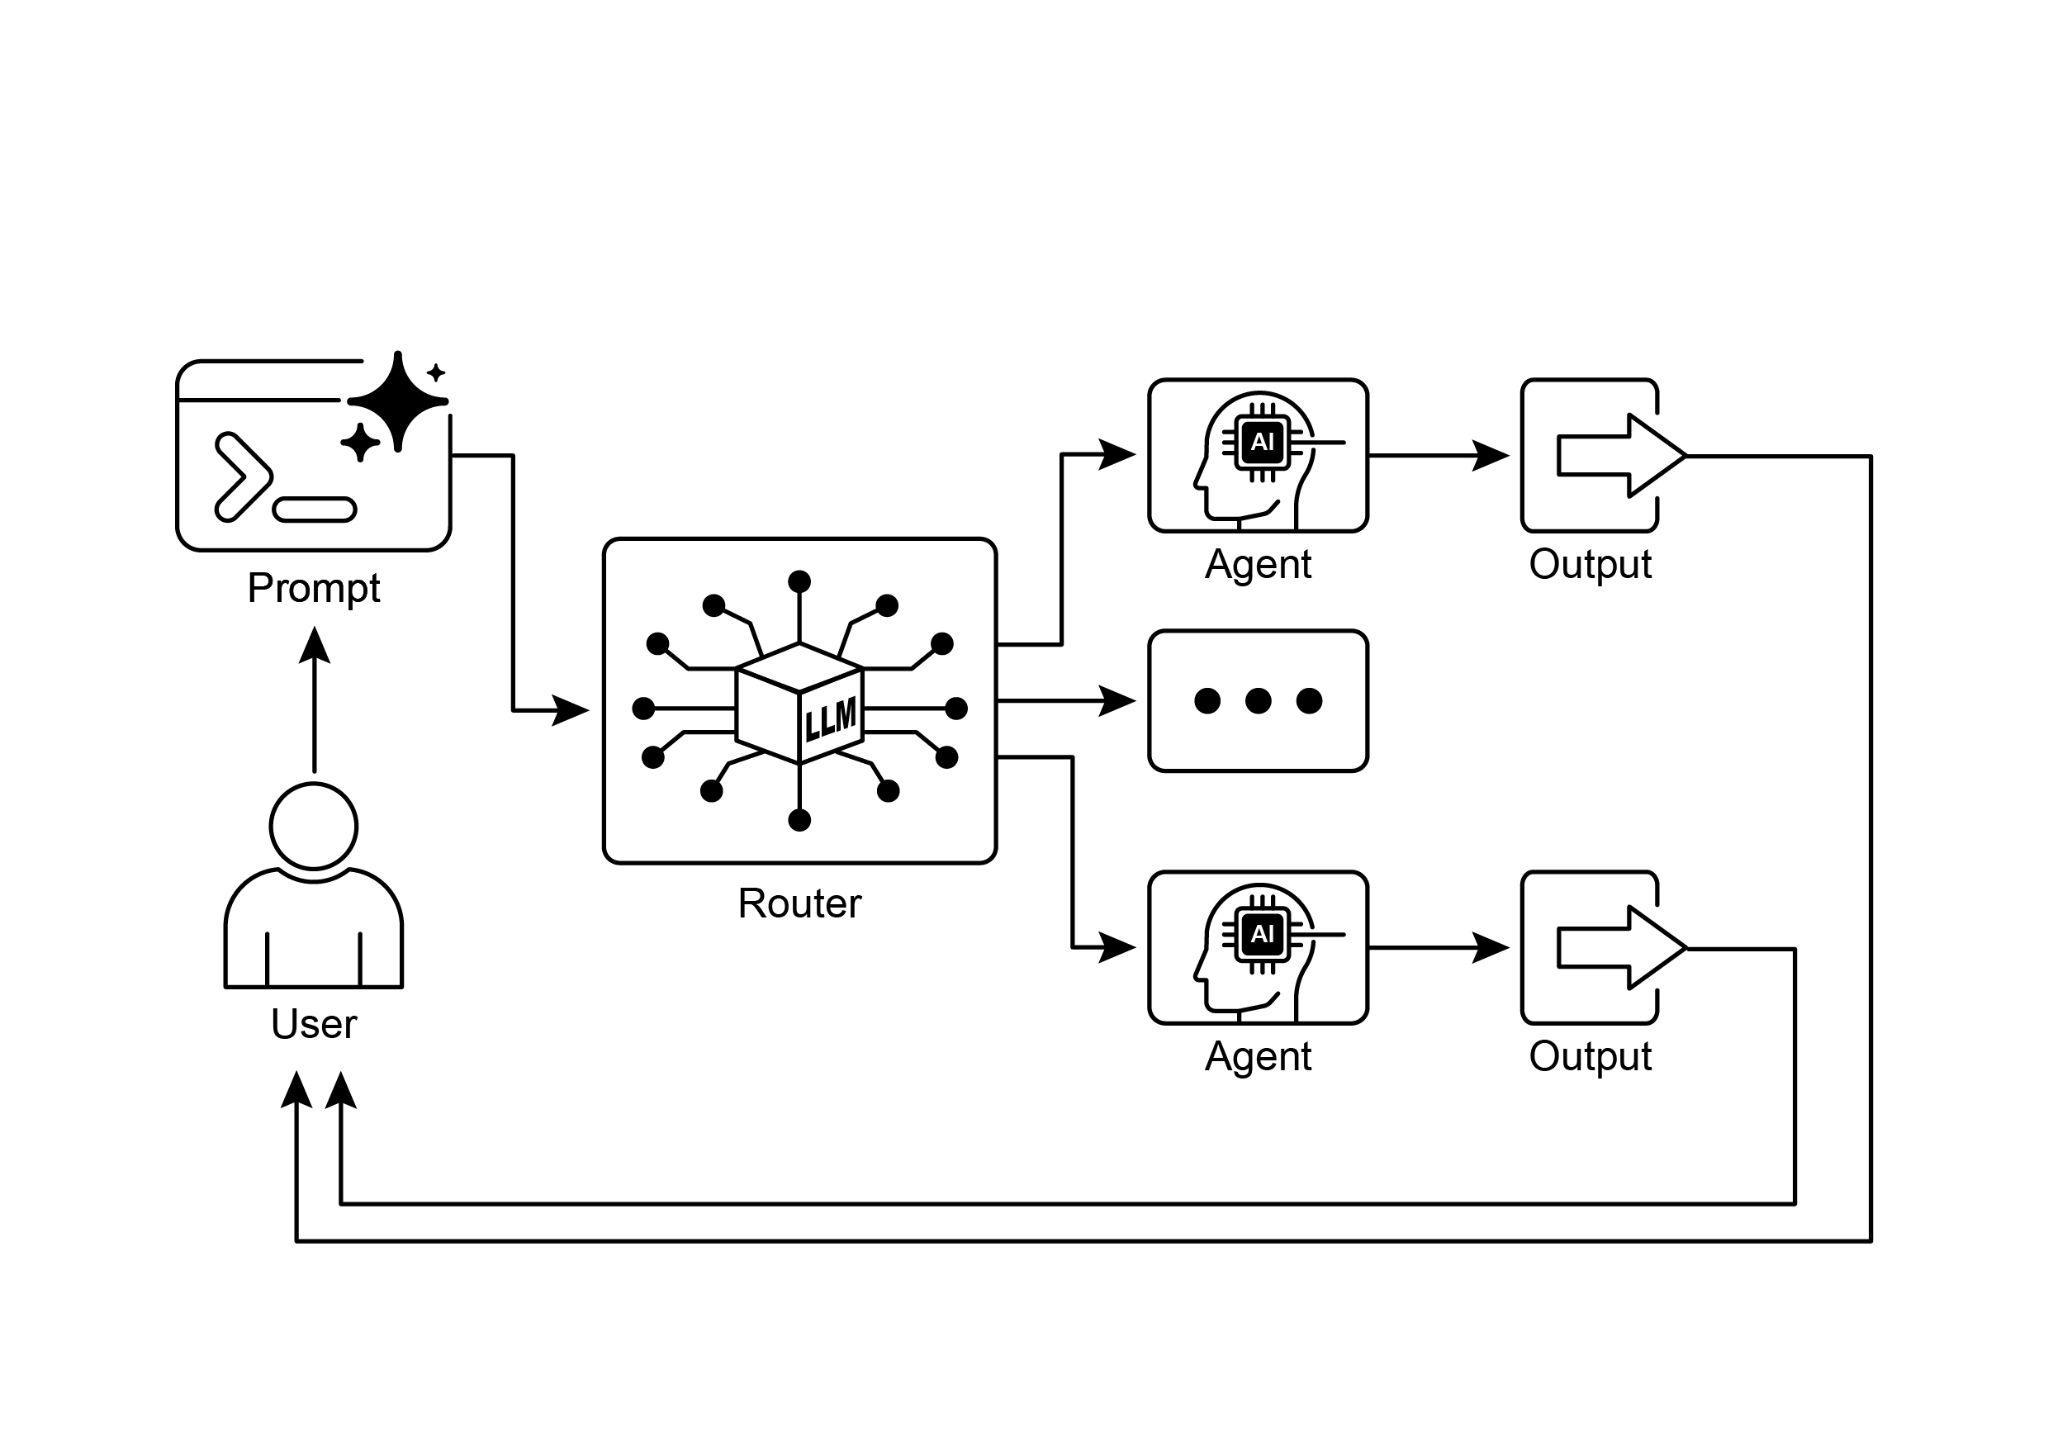